# 3. Aligning datasets

In [1]:
from pathlib2 import Path
import papylio as pp
import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import AffineTransform

%matplotlib inline

## Experiment import

Note that the sequencing data is automatically imported.

In [2]:
experiment_path = Path(r'C:\Users\user\Desktop\SPARXS example dataset')

In [3]:
exp = pp.Experiment(experiment_path)

Import files: 100%|██████████████████████████████████████████████████████████████| 4190/4190 [00:00<00:00, 6600.31it/s]



File(Single-molecule data - bead slide\Bead slide TIRF 561 001) used as mapping

Initialize experiment: 
C:\Users\user\Desktop\SPARXS example dataset

Import sequencing data:
Sequencing data\sequencing_data.nc


In [4]:
files_bead_slide = exp.files.select('Bead slide', 'name')
files_green_laser = exp.files.select('Single-molecule data - green laser', 'relativePath')
files_red_laser_before = exp.files.select('Single-molecule data - red laser before', 'relativePath')
files_red_laser_after = exp.files.select('Single-molecule data - red laser after', 'relativePath')

In [5]:
files_red_laser_before.movie.illumination_arrangement = [1]
files_red_laser_after.movie.illumination_arrangement = [1]

## Coarse tile alignment

### Generate tile alignment files

To perform the tile alignment, the first step is to create the mapping or alignment file for each tile. This file contains the point sets to be aligned and uses the same format as the mapping file used for channel alignment. To create the file the single-molecule coordinates of all `files_green_laser` are calculated relative to the stage position and are merged into a single array. This constitutes the single-molecule point set. The coordinates of the sequencing data are separated for each tile and then for each tile an `.nc` alignment file is created in the `Analysis\Tile mappings` folder. 

In [6]:
files_green_laser[100].dataset

<xarray.Dataset>
Dimensions:               (molecule: 830, channel: 2, dimension: 2, frame: 400)
Coordinates:
    molecule_in_file      (molecule) int32 0 1 2 3 4 5 ... 825 826 827 828 829
    file                  (molecule) |S58 b'Single-molecule data - green lase...
  * channel               (channel) int64 0 1
  * dimension             (dimension) |S1 b'x' b'y'
    time                  (frame) float64 0.0 0.123 0.246 ... 48.62 48.75 48.87
  * frame                 (frame) int32 0 1 2 3 4 5 ... 394 395 396 397 398 399
    illumination          (frame) int32 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
Dimensions without coordinates: molecule
Data variables:
    selected              (molecule) bool False False False ... False False
    coordinates           (molecule, channel, dimension) float64 106.3 ... 373.4
    intensity             (molecule, channel, frame) float64 1.405e+04 ... -8...
    intensity_raw         (molecule, channel, frame) float64 8.622e+03 ... -9...
    FRET                  (molecule, frame) float64 0.3915 0.437 ... 0.0 0.0
    intensity_red_before  (molecule, channel) float64 68.52 ... 5.707e+03
    intensity_red_after   (molecule, channel) float64 32.34 6.233e+03 ... 161.8

In [7]:
mapping_sequence_name = 'HJ_general'

exp.generate_tile_mappings(files_green_laser, 
                           mapping_sequence_name=mapping_sequence_name, 
                           surface=0,
                           name='Single-molecule data')

Make tile mappings: 100%|████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.17it/s]


`mapping sequence name` This is the name of the reference sequence(s) that is/are fluorescently labelled. This should be one of the references defined in the Reference.fasta file. Later when the single molecules are coupled to a sequence, all relevant sequences will be used. 


`surface` defines from which surface of the MiSeq flow cell the data should be used.
0 corresponds to tiles 1101, 1102, ... located on the thin glass surface that is usually imaged with objective-type TIRF. 
1 corresponds to tiles 2101, 2102, ... located on the thick glass surface that is usually imaged with prism-type TIRF.

`name` can be a self determined name. This can be used when multiple tile mappings are necessary for different file sets, which may for example be neccesary when the flow cell is taken off the stage between scans.

### Perform tile alignment

The previous step generates mapping objects, which can be aligned using various algorithms.
Here we first set initial rotation, reflection and scaling based on global registration and then perform cross-correlation on synthetic images.
Correct alignment of our data requires reflection, however, for demonstration purposes, at first we do not apply this reflection (i.e. both values of the scale are positive). This will thus result in incorrect alignment. Using `%matplotlib qt` the plots will be made in separate windows, so you can zoom in manually.

See the [MatchPoint manual](https://matchpoint.readthedocs.io/en/latest/_generated/matchpoint.core.MatchPoint.html#matchpoint.core.MatchPoint.cross_correlation) for definition of the arguments.

In [8]:
tile_mappings = exp.tile_mappings[exp.tile_mappings.name.regex('Single-molecule data')]

C:\Users\user\miniconda3\envs\trace_analysis\lib\site-packages\objectlist\base.py:214: FutureWarning: The input object of type 'MatchPoint' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'MatchPoint', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return type(self)(np.array(self.data)[item].tolist(), **self.dict_without_data)
C:\Users\user\miniconda3\envs\trace_analysis\lib\site-packages\objectlist\base.py:214: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return type(se

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Serial processing


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.32s/it]


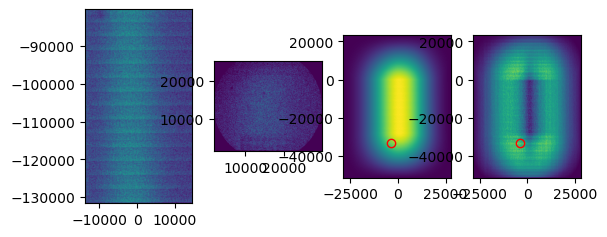

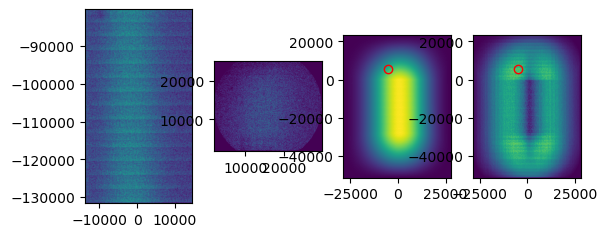

In [9]:
# Incorrect alignment
# Use "%matplotlib qt" to open in a seprate window for closer examination.
tile_mappings.transformation = AffineTransform(scale=[29.51, 29.51], rotation=0.0024) # Obtained from step 1 in the alignment process

tile_mappings.serial.cross_correlation(peak_detection='auto', kernel_size=7, gaussian_sigma=1, divider=20, 
                                           subtract_background='minimum_filter', plot=True)

When performing the cross correlation, you can set plot to True. This plot can help you judge whether the tile was aligned correctly. Above you can see an example of a tile that was not correctly aligned. Zoom in on the peak that has been detected in the right plot. In this case, you see that the peak is not very distinguishable from background levels. While for a correct tile alignment (below), the  peak is clearly much higher than the background. In case you don't see a clear peak, it is likely that the alignment is incorrect.

If tile mapping is not successful, one can try to optimize the arguments. The first thing I try is increasing the divider. This is the number by which the point set coordinates are divided to obtain pixel indices. Keep in mind that the higher the divider, the longer the computation time. The kernel size is the size in pixels of the gaussian kernel, choosing this one smaller will also increase the computation time. Gaussian sigma is the standard deviation of the gaussian kernel.

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Serial processing


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 67.15it/s]


Serial processing


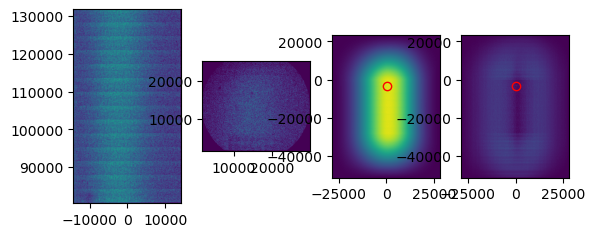

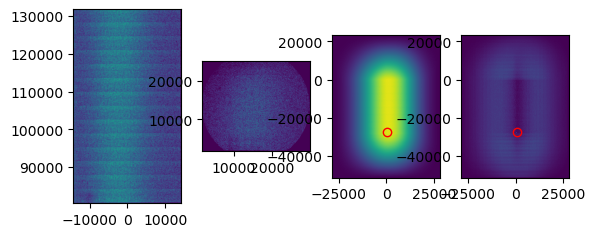

In [10]:
# Correct alignment
tile_mappings.transformation = AffineTransform(scale=[29.51, -29.51], rotation=0.0024) # Obtained from step 1 in the alignment process

tile_mappings.serial.cross_correlation(peak_detection='auto', kernel_size=7, gaussian_sigma=1, divider=20, 
                                       subtract_background='minimum_filter', plot=True)
tile_mappings.save()

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Serial processing


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.12s/it]


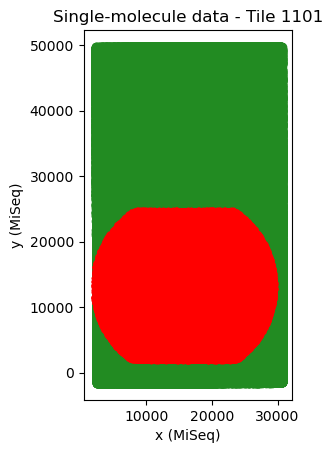

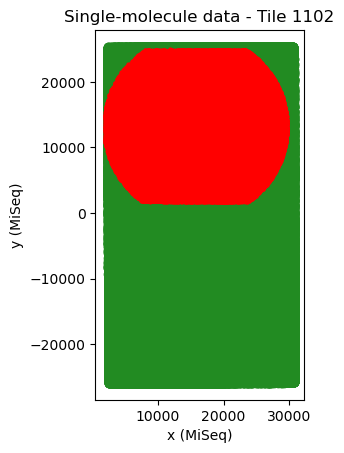

In [11]:
tile_mappings.show_mapping_transformation(crop=False, save=True)

The difference in translation between tiles in x and y (in MiSeq units) should be approximately 50-100 and 30000 (MiSeq v2 flow cells) or 25000 (MiSeq v3 flow cells). Whenever the tiles are neatly arranged in a diagonal line, tile mapping has usually worked well. For a flow cell with only two tiles it is harder to judge from the pattern, because there are only two tiles. In that case, it is best to judge from the cross correlation and from the translation distances.

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='Translation x (MiSeq)', ylabel='Translation y (MiSeq)'>)

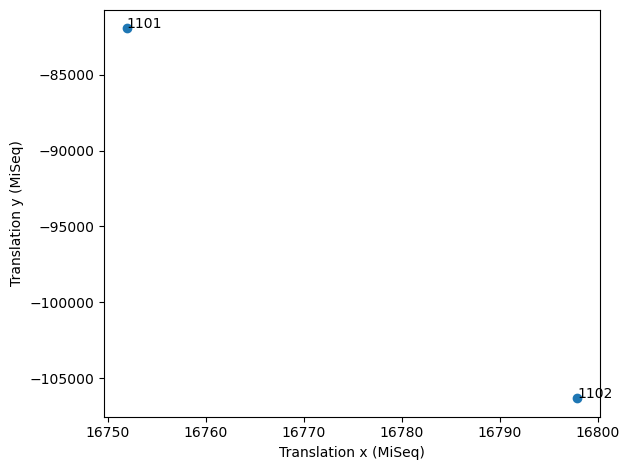

In [12]:
tile_mappings.scatter_parameters('translation', 'translation', dimension_x=0, dimension_y=1, indices=None, figure=None, save=False)

## Extract sequencing data per FOV

After the performing tile alignment, we roughly know which sequences belong to which field of view. Therefore, in the next step we obtain the sequencing data for each field of view and store it in a `_sequencing_data.nc` file.

In [13]:
files_green_laser.parallel_processing_kwargs['require'] = 'sharedmem'
exp.transform_sequencing_to_single_molecule_coordinates()
files_green_laser.get_sequencing_data(margin=5, mapping_name='Single-molecule data')
files_green_laser.parallel_processing_kwargs.pop('require')

  0%|▎                                                                                 | 4/896 [00:00<00:28, 31.77it/s]

Serial processing


100%|████████████████████████████████████████████████████████████████████████████████| 896/896 [04:30<00:00,  3.31it/s]


'sharedmem'

`margin` add an extra margin of sequencing data around the single-molecule data to allow for some inaccuracy in the tile alignment. The unit is μm.

`mapping_name` should be the same name given to the tile alignment earlier.

## Fine FOV alignment


In this step, each single-molecule FOV is matched to the sequencing data. For each single-molecule FOV there might
be slight deviations in molecule position due to image aberrations or inaccuracies in the stage position. Therefore, the
translation, rotation and scaling for each single-molecule FOV are fine-tuned. 

### Generate FOV alignment files

Now we use the single-molecule coordinates and sequencing data for each field of view to generate an alignment file `_sequencing_match.nc` (with similar format as the channel mapping and tile mapping).

In [14]:
files_green_laser.parallel.generate_sequencing_match(overlapping_points_threshold=25,
                                                   excluded_sequence_names=['CalSeq', '*'], 
                                                   plot=False)

  0%|                                                                                          | 0/896 [00:00<?, ?it/s]

Parallel processing


100%|████████████████████████████████████████████████████████████████████████████████| 896/896 [00:38<00:00, 23.34it/s]


`overlapping_points_threshold` Indicates the minimum number of points within the overlapping area between the datasets, for the file to be included.

`excluded_sequence_names` can be used to exclude sequences that are not fluorescent and thus can not be seen in the single-molecule dataset. These should follow the same naming as used in the reference.fasta file. In our case the CalSeq sequence was not fluorescent, and was therefore excluded. `*` is the reference name given by Bowtie2 for any sequence that could not be aligned.

In [15]:
sequencing_matches = exp.sequencing_matches(files_green_laser)

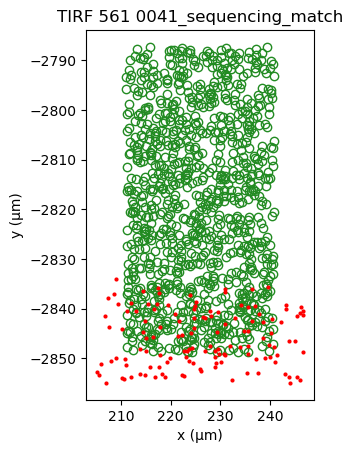

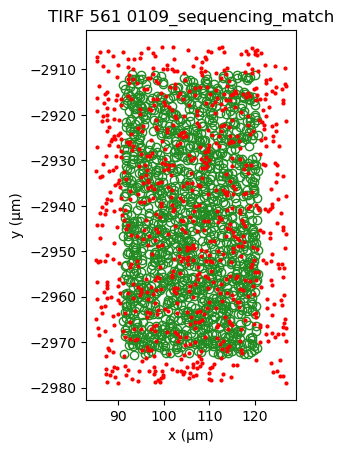

In [16]:
sequencing_matches[0].show()
sequencing_matches[50].show()

One way of determining whether the alignment is correct, is by looking at the inter point set distance histogram. A correct match should show a clear peak at small distances (absent here).

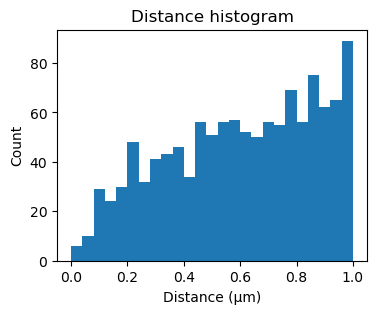

In [17]:
fig, ax = plt.subplots(figsize=(4,3))
ax.hist(sequencing_matches[50].distance_matrix().flatten(), bins=25, range=(0,1))
ax.set_xlabel('Distance (μm)')
ax.set_ylabel('Count')
_ = ax.set_title('Distance histogram')

### Perform FOV alignment

Then the datasets for each FOV are aligned.

In [18]:
sequencing_matches.transformation = AffineTransform() # Reset alignment
sequencing_matches.transformation_inverse = AffineTransform()

In [19]:
sequencing_matches.serial.cross_correlation(divider=0.1, kernel_size=7, gaussian_sigma=1, crop=True, plot=False)

  0%|▏                                                                                 | 2/744 [00:00<00:48, 15.33it/s]

Serial processing


100%|████████████████████████████████████████████████████████████████████████████████| 744/744 [02:23<00:00,  5.19it/s]


In [20]:
# bounds = ((0.97, 1.03), (-0.05, 0.05), (-5, 5), (-5, 5))
# sequencing_matches.parallel.kernel_correlation(bounds, sigma=0.125, crop=True,
#                                          strategy='best1bin', maxiter=1000, popsize=50, tol=0.01,
#                                          mutation=0.25, recombination=0.7, seed=None, callback=None, disp=False,
#                                          polish=True, init='sobol', atol=0, updating='immediate', workers=1,
#                                          constraints=())

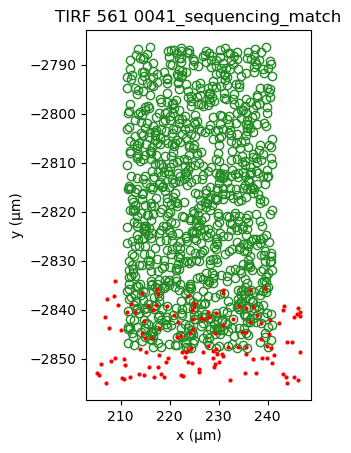

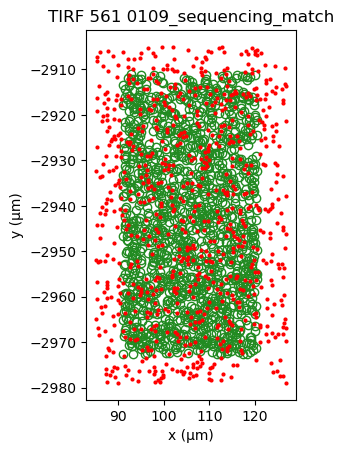

In [21]:
sequencing_matches[0].show()
sequencing_matches[50].show()

Applying cross-correlation, shows the formation of a peak, indicating better alignment.

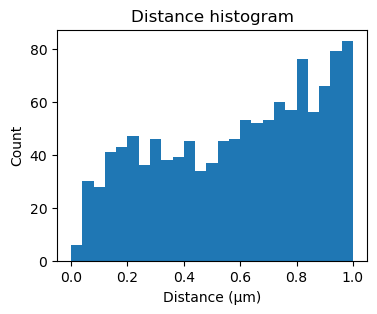

In [22]:
fig, ax = plt.subplots(figsize=(4,3))
ax.hist(sequencing_matches[50].distance_matrix().flatten(), bins=25, range=(0,1))
ax.set_xlabel('Distance (μm)')
ax.set_ylabel('Count')
_ = ax.set_title('Distance histogram')

In [23]:
bounds = ((0.99, 1.01), (-0.01, 0.01), (-1, 1), (-1, 1))
sequencing_matches.parallel.kernel_correlation(bounds, sigma=0.125, crop=True,
                                         strategy='best1bin', maxiter=1000, popsize=50, tol=0.001,
                                         mutation=0.25, recombination=0.7, seed=None, callback=None, disp=False,
                                         polish=True, init='sobol', atol=0, updating='immediate', workers=1,
                                         constraints=())

  0%|                                                                                          | 0/744 [00:00<?, ?it/s]

Parallel processing


100%|████████████████████████████████████████████████████████████████████████████████| 744/744 [01:09<00:00, 10.75it/s]


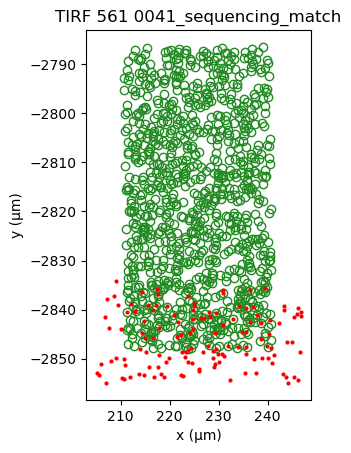

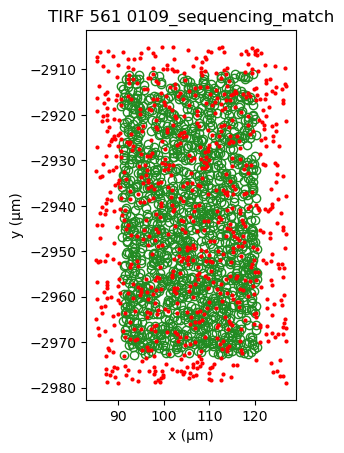

In [24]:
sequencing_matches[0].show()
sequencing_matches[50].show()

Additionally applying kernel correlation, creates a sharper peak.

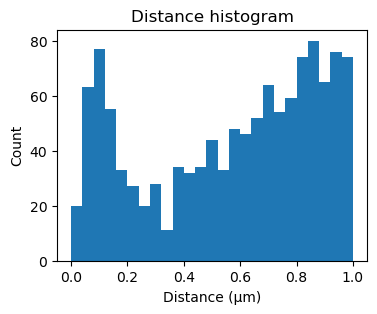

In [25]:
fig, ax = plt.subplots(figsize=(4,3))
ax.hist(sequencing_matches[50].distance_matrix().flatten(), bins=25, range=(0,1))
ax.set_xlabel('Distance (μm)')
ax.set_ylabel('Count')
_ = ax.set_title('Distance histogram')

In [26]:
sequencing_matches.save()

 21%|████████████████▊                                                              | 158/744 [00:00<00:00, 837.46it/s]

Parallel processing


100%|██████████████████████████████████████████████████████████████████████████████| 744/744 [00:00<00:00, 1370.29it/s]


Plotting the alignments from all fields of view (FOVs) can also indicate whether there is correct alignment. Overall, the FOVs should align nicely on a grid. In case a FOV deviates from the grid, then it is likely misaligned. Here, nearly all FOVs are aligned well, except the 3rd FOV from the left in the bottom row.

  1%|▋                                                                                 | 3/381 [00:00<00:15, 25.02it/s]

Serial processing


100%|████████████████████████████████████████████████████████████████████████████████| 381/381 [00:15<00:00, 24.66it/s]


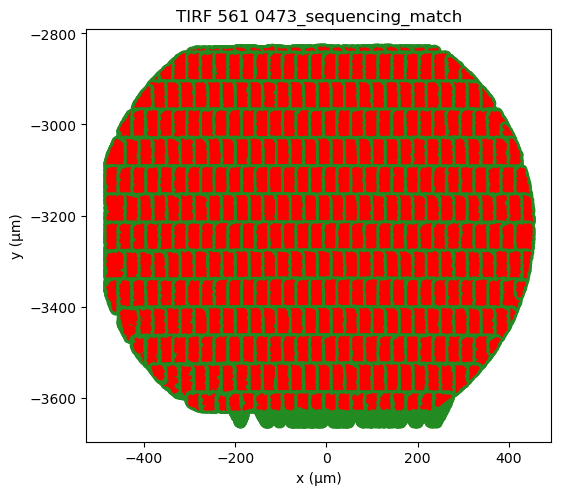

In [27]:
# Use "%matplotlib qt" to open in a seprate window for closer examination.
%matplotlib inline
fig, ax = plt.subplots(figsize=(6,6))
sequencing_matches[0:381].serial.show(crop=True, axis=ax)

Also from the outlines of the aligned datasets one can spot misaligned FOVs, e.g. the 3rd FOV from the left in the bottom row.

  4%|███▌                                                                            | 17/381 [00:00<00:02, 151.66it/s]

Serial processing


100%|███████████████████████████████████████████████████████████████████████████████| 381/381 [00:03<00:00, 126.13it/s]


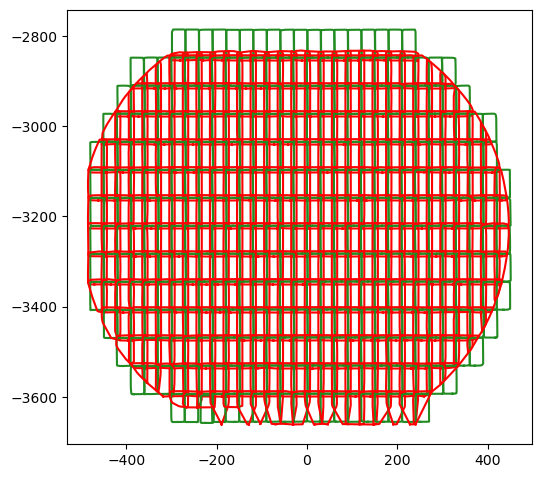

In [28]:
fig, ax = plt.subplots(figsize=(6,6))
_ = sequencing_matches[0:381].serial.show_outline(axis=ax)

## Determine corresponding pairs

### Determine appropriate distance threshold 

To determine an appropriate distance threshold, we make a histogram of the distances smaller than 1 μm.

In [29]:
distance_matrices = sequencing_matches[0:381].serial.distance_matrix(max_distance=1).todense().flatten().squeeze()
distances = np.array(np.hstack(distance_matrices)).squeeze()
distances = distances[distances>0]

  2%|█▎                                                                                | 6/381 [00:00<00:06, 56.45it/s]

Serial processing


 30%|███████████████████████▌                                                      | 115/381 [00:00<00:00, 1086.73it/s]

Serial processing


 21%|████████████████▌                                                               | 79/381 [00:00<00:00, 780.87it/s]

Serial processing


100%|█████████████████████████████████████████████████████████████████████████████| 381/381 [00:00<00:00, 24340.55it/s]


Serial processing


In [30]:
def random_distance_distribution(r, N_dist, N_m, A, bin_width):
    # Ndist = Ns * Nd
    return (N_dist - N_m) / A * 2 * np.pi * r * bin_width

def match_distance_distribution(r, N_m, sigma, bin_width):
    # sigma = np.sqrt(sigma_s**2 + sigma_d**2)b
    return 2 * N_m * np.exp(-(r**2 + bin_width**2 / 4) / (2 * sigma**2)) * np.sinh(r * bin_width / (2* sigma**2))

def total_distance_distribution(r, N_dist, N_m, A, sigma, bin_width):
    return match_distance_distribution(r, N_m, sigma, bin_width) + random_distance_distribution(r, N_dist, N_m, A, bin_width)

In [31]:
A = np.sum([mapping.destination_cropped_area for mapping in sequencing_matches[0:381]])
N_s = np.sum([mapping.source_cropped.shape[0] for mapping in sequencing_matches[0:381]]).astype(float)
N_d = np.sum([mapping.destination_cropped.shape[0] for mapping in sequencing_matches[0:381]]).astype(float)
N_dist = N_s * N_d

Text(0.55, 0.85, 'Fit:\n\n7.10e+04\n\n0.0966')

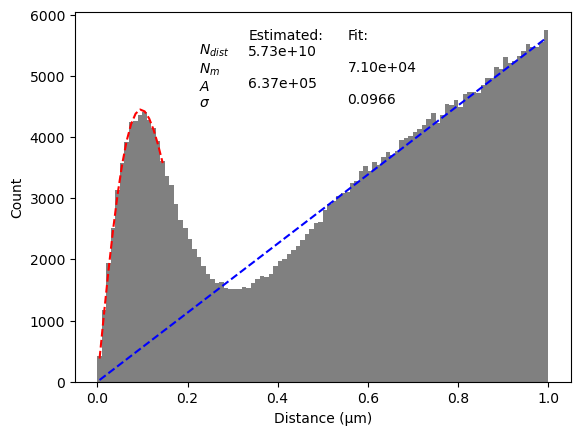

In [32]:
r_range = (0,1)
number_of_bins = 100
bin_width = (r_range[1]-r_range[0])/number_of_bins

fig, ax = plt.subplots()
counts, bins, _ = ax.hist(distances, number_of_bins, range=r_range, color='gray')
bin_centers = r = (bins[:-1]+bins[1:])/2

fit_selection = bin_centers < 0.15

from scipy.optimize import curve_fit
def fun2(r, N_m, sigma):
    return match_distance_distribution(r, N_m, sigma, bin_width)

popt, pcov = curve_fit(fun2, bin_centers[fit_selection], counts[fit_selection], p0=(N_s, 0.2), bounds=((0,0),(np.inf, np.inf)))

N_m_fit, sigma_fit = popt

ax.plot(bin_centers[fit_selection], match_distance_distribution(bin_centers[fit_selection], N_m_fit, sigma_fit, bin_width), 
        label='Match distance fit', c='r', linestyle='dashed')

ax.plot(bin_centers, random_distance_distribution(bin_centers, N_dist, N_m_fit, A, bin_width), 
        label='Match distance fit', c='b', linestyle='dashed')


ax.set_xlabel('Distance (μm)')
ax.set_ylabel('Count')


ax.text(0.25, 0.85, '\n$N_{dist}$\n$N_m$\n$A$\n$\sigma$', size=10, rotation=0,
         ha="left", va="center", transform=ax.transAxes,
         bbox=dict(boxstyle="round", ec='white', fc='white')
         )

ax.text(0.35, 0.85, f'Estimated:\n{N_dist:.2e}\n\n{A:.2e}\n', size=10, rotation=0,
         ha="left", va="center", transform=ax.transAxes,
         bbox=dict(boxstyle="round", ec='white', fc='white')
         )

ax.text(0.55, 0.85, f'Fit:\n\n{N_m_fit:.2e}\n\n{sigma_fit:.4f}', size=10, rotation=0,
         ha="left", va="center", transform=ax.transAxes,
         bbox=dict(boxstyle="round", ec='white', fc='white')
         )


In the plot a peak can be seen for small distances, which is the result of corresponding points. For larger distances, there is a linear increase, which is caused by randomly matched points. We fit the first part of the peak to a Gaussian to determine the point set parameters for matching points (red). Two other parameters (A and N_{dist} can be estimated from the data directly and determine the linear relation (blue). 

The threshold should be chosen so that it includes most corresponding points, but excludes randomly matched points. To determine a good value for the threshold we estimate the precision and recall.

In [33]:
from scipy.special import factorial

def f_random(r, rho):
    return 2*rho*np.pi*r

def P_random(r, N, rho):
    _lambda = rho * np.pi * r ** 2
    return _lambda**N * np.exp(-_lambda) / factorial(N)

def f_match(r, sigma):
    return r/(sigma**2)*np.exp(-r**2/(2*sigma**2))

def P_match(r, sigma):
    return 1-np.exp(-r**2/(2*sigma**2))

def P_TP(r, alpha_s, alpha_d, sigma, rho_s, rho_d):
    return alpha_s * alpha_d * P_match(r, sigma) * P_random(r, 0, rho_s) * P_random(r, 0, rho_d)

def P_FP(r, alpha_s, alpha_d, sigma, rho_s, rho_d):
    return 0.5*alpha_s * alpha_d * (1 - P_match(r, sigma)) * P_random(r, 1, rho_d) * \
                (alpha_s * (1-P_match(r,sigma)) + (1-alpha_s)) * P_random(r, 0, rho_s) + \
           0.5*alpha_s * alpha_d * (1 - P_match(r, sigma)) * P_random(r, 1, rho_s) * \
                (alpha_d * (1-P_match(r,sigma)) + (1-alpha_d)) * P_random(r, 0, rho_d) + \
           alpha_s * (1-alpha_d) * P_random(r, 1, rho_d) * \
                (alpha_s * (1-P_match(r,sigma)) + (1-alpha_s)) * P_random(r, 0, rho_s) + \
           (1-alpha_s) * alpha_d * P_random(r, 1, rho_s) * \
                (alpha_d * (1-P_match(r,sigma)) + (1-alpha_d)) * P_random(r, 0, rho_d)


def P_P_total(*args):
    return P_TP(*args) + P_FP(*args)

def P_TN(r, alpha_s, alpha_d, sigma, rho_s, rho_d):
    return  alpha_s * (1-alpha_d) * (1-P_random(r, 1, rho_d)) + \
            alpha_s * (1-alpha_d) * P_random(r, 1, rho_d) * \
            (   alpha_s * (P_match(r,sigma) + (1-P_match(r,sigma))*(1-P_random(r, 0, rho_s))) + \
                (1-alpha_s) * (1-P_random(r, 0, rho_s))   ) + \
            (1-alpha_s) * alpha_d * (1-P_random(r, 1, rho_s)) + \
            (1-alpha_s) * alpha_d * P_random(r, 1, rho_s) * \
            (   alpha_d * (P_match(r,sigma) + (1-P_match(r,sigma))*(1-P_random(r, 0, rho_d))) + \
                (1-alpha_d) * (1-P_random(r, 0, rho_d))   ) + \
            (1-alpha_s) * (1-alpha_d)

def P_FN(r, alpha_s, alpha_d, sigma, rho_s, rho_d):
    return  alpha_s * alpha_d * P_match(r, sigma) * (1-P_random(r, 0, rho_s) * P_random(r, 0, rho_d)) + \
            0.5*alpha_s * alpha_d * (1-P_match(r, sigma)) * (1-P_random(r, 1, rho_d)) + \
            0.5*alpha_s * alpha_d * (1-P_match(r, sigma)) * P_random(r, 1, rho_d) * \
            (   alpha_s * (P_match(r,sigma) + (1-P_match(r,sigma))*(1-P_random(r, 0, rho_s))) + \
                (1-alpha_s) * (1-P_random(r, 0, rho_s))   ) + \
            0.5*alpha_s * alpha_d * (1-P_match(r, sigma)) * (1-P_random(r, 1, rho_s)) + \
            0.5*alpha_s * alpha_d * (1-P_match(r, sigma)) * P_random(r, 1, rho_s) * \
            (   alpha_d * (P_match(r,sigma) + (1-P_match(r,sigma))*(1-P_random(r, 0, rho_d))) + \
                (1-alpha_d) * (1-P_random(r, 0, rho_d))   )
    
def P_N_Total(*args):
    return P_TN(*args) + P_FN(*args)

In [34]:
rho_s = N_s/A
rho_d = N_d/A
alpha_s = N_m_fit / N_d
alpha_d = N_m_fit / N_s
N = N_m_fit / alpha_s / alpha_d
rho = N/A

print('rho_s =', rho_s)
print('rho_d =', rho_d)
print('alpha_s =', alpha_s)
print('alpha_d =', alpha_d)
print('N =', N)

rho_s = 0.66868076452285
rho_d = 0.21095862262662107
alpha_s = 0.5284088392472044
alpha_d = 0.16670496120950204
N = 806532.6851972315


In [35]:
tp = P_TP(r, alpha_s, alpha_d, sigma_fit, rho_s, rho_d)
fp = P_FP(r, alpha_s, alpha_d, sigma_fit, rho_s, rho_d)
tn = P_TN(r, alpha_s, alpha_d, sigma_fit, rho_s, rho_d)
fn = P_FN(r, alpha_s, alpha_d, sigma_fit, rho_s, rho_d)

sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
precision = tp/(tp+fp)
fallout = fp/(fp+tn)

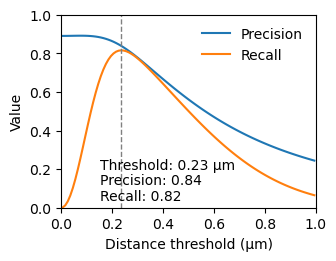

In [36]:
figure, axis = plt.subplots(figsize=(3.25, 2.5), layout='constrained')

axis.plot(r, precision, label='Precision', ls='-')
axis.plot(r, sensitivity, label='Recall', ls='-')

axis.set_xlim(0,1)
axis.set_ylim(0,1)
axis.legend(loc='upper right', frameon=False)

axis.set_xlabel('Distance threshold (μm)')
axis.set_ylabel('Value')

threshold = r[sensitivity.argmax()]
# threshold = 0.20
tp_t = P_TP(threshold, alpha_s, alpha_d, sigma_fit, rho_s, rho_d) * N
# tp_t = P_TP(threshold, alpha_s, alpha_d, sigma_fit, rho_s_v[sensitivity==sensitivity.max()], rho_d_v[sensitivity==sensitivity.max()]) * N
fp_t = P_FP(threshold, alpha_s, alpha_d, sigma_fit, rho_s, rho_d) * N
tn_t = P_TN(threshold, alpha_s, alpha_d, sigma_fit, rho_s, rho_d) * N
fn_t = P_FN(threshold, alpha_s, alpha_d, sigma_fit, rho_s, rho_d) * N
precision_at_threshold =  (tp_t/(tp_t+fp_t)).item()
sensitivity_at_threshold = (tp_t/(tp_t+fn_t)).item()

# threshold=0.2
axis.vlines(threshold, 0, 1, ls='--', color='grey', lw=1, label='Chosen threshold')

text = ['Threshold: ' +f'{threshold:.2}' + r' µm',
        'Precision: ' + f'{precision_at_threshold:.2}',
        'Recall: ' + f'{sensitivity_at_threshold:.2}',
       ]

x = 0.15
ps = 0.2+-0.08*np.arange(3)
for i, t in enumerate(text):
    axis.text(x, ps[i], t, transform=axis.transAxes, ha='left', va='baseline', )

# figure.savefig(main_path / 'precision and sensitivity model.pdf', dpi=300)

We chose the threshold at the maximum recall, as it gives us the most data points, while still obtaining a resonable precision.

### Determine corresponding pairs

In [37]:
sequencing_matches.destination_distance_threshold = 0.22 # μm
sequencing_matches.determine_matched_pairs()
sequencing_matches.save()

  0%|                                                                                          | 0/744 [00:00<?, ?it/s]

Parallel processing


 20%|███████████████▉                                                               | 150/744 [00:00<00:00, 792.57it/s]

Parallel processing


100%|██████████████████████████████████████████████████████████████████████████████| 744/744 [00:00<00:00, 1358.43it/s]


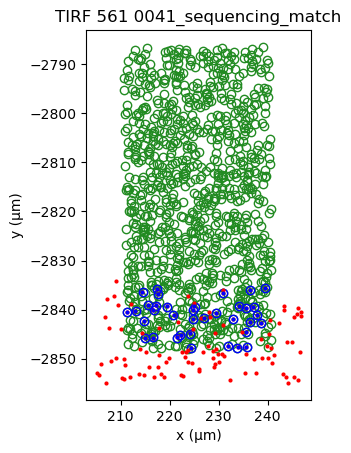

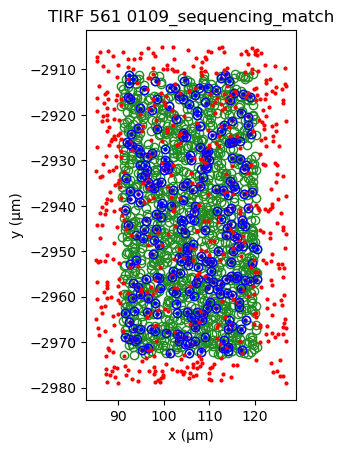

In [38]:
sequencing_matches[0].show()
sequencing_matches[50].show()

  1%|▊                                                                                 | 4/381 [00:00<00:09, 38.81it/s]

Serial processing


100%|████████████████████████████████████████████████████████████████████████████████| 381/381 [00:15<00:00, 24.68it/s]


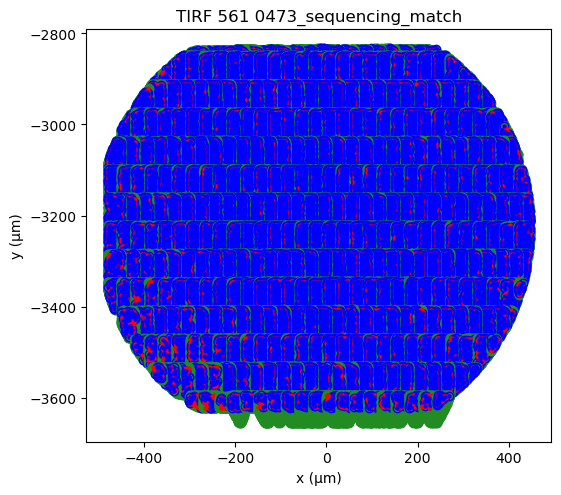

In [39]:
# Use matplotlib qt to open in a seprate window for closer examination.
%matplotlib inline
# %matplotlib qt
fig, ax = plt.subplots(figsize=(6,6))
sequencing_matches[0:381].serial.show(crop=True, axis=ax)